In [12]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from wordcloud import WordCloud
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/Users/mement/Documents/Vietnamese Sentiment Analysis/data/data.csv')
df.head()

,content,label,start
0,Áo bao đẹp ạ!,POS,5
1,Tuyệt vời,POS,5
2,2day ao khong giong trong,NEG,1
3,"Mùi thơm,bôi lên da mềm da",POS,5
4,"Vải đẹp, dày dặn",POS,5


In [4]:
# Kích thước và kiểu dữ liệu
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nDataset info:")
df.info()

Dataset shape: (31460, 3)

Data types:
content    object
label      object
start       int64
dtype: object

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  31436 non-null  object
 1   label    31460 non-null  object
 2   start    31460 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 737.5+ KB


In [5]:
# Độ dài text
df['text_length'] = df['content'].str.len()
print("Text length statistics:")
print(df['text_length'].describe())

# Số từ trong mỗi text
df['word_count'] = df['content'].str.split().str.len()
print("\nWord count statistics:")
print(df['word_count'].describe())

# Xem một vài samples
print("\nSample texts:")
for i in range(5):
    print(f"Text {i}: {df['content'].iloc[i]}")
    print(f"Label: {df['label'].iloc[i]}")
    print("-" * 50)

Text length statistics:
count    31436.000000
mean        43.914429
std         38.567678
min          1.000000
25%         19.000000
50%         31.000000
75%         55.000000
max        303.000000
Name: text_length, dtype: float64

Word count statistics:
count    31436.000000
mean        10.195699
std          8.620445
min          1.000000
25%          5.000000
50%          8.000000
75%         13.000000
max         74.000000
Name: word_count, dtype: float64

Sample texts:
Text 0: Áo bao đẹp ạ!
Label: POS
--------------------------------------------------
Text 1: Tuyệt vời
Label: POS
--------------------------------------------------
Text 2: 2day ao khong giong trong
Label: NEG
--------------------------------------------------
Text 3: Mùi thơm,bôi lên da mềm da
Label: POS
--------------------------------------------------
Text 4: Vải đẹp, dày dặn
Label: POS
--------------------------------------------------


Label distribution:
label
POS    20093
NEG     6669
NEU     4698
Name: count, dtype: int64

Label proportions:
label
POS    0.638684
NEG    0.211983
NEU    0.149332
Name: proportion, dtype: float64


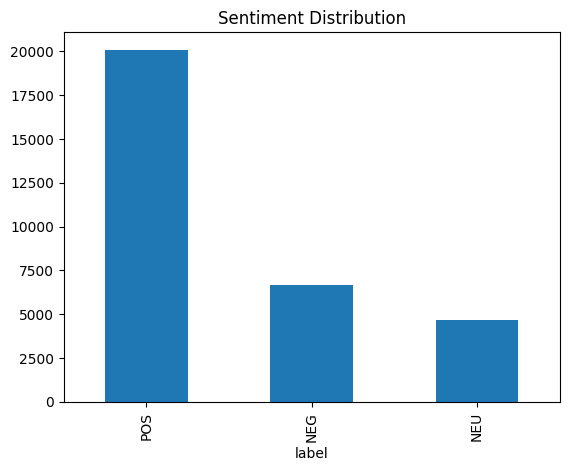

In [6]:
# Distribution của labels
print("Label distribution:")
print(df['label'].value_counts())
print("\nLabel proportions:")
print(df['label'].value_counts(normalize=True))

# Visualize
import matplotlib.pyplot as plt
df['label'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.show()

In [7]:
# Xem unique values trong cột start
print("Unique values in 'start' column:")
print(df['start'].value_counts())

# Mối quan hệ giữa start và label
print("\nCrosstab start vs label:")
print(pd.crosstab(df['start'], df['label']))

Unique values in 'start' column:
start
5    13286
4     6807
3     4698
1     3529
2     3140
Name: count, dtype: int64

Crosstab start vs label:
label   NEG   NEU    POS
start                   
1      3529     0      0
2      3140     0      0
3         0  4698      0
4         0     0   6807
5         0     0  13286


In [8]:
# Missing values
print("Missing values:")
print(df.isnull().sum())

# Duplicate rows
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Empty or very short texts
print(f"Empty texts: {(df['content'].str.len() == 0).sum()}")
print(f"Very short texts (<5 chars): {(df['content'].str.len() < 5).sum()}")

Missing values:
content        24
label           0
start           0
text_length    24
word_count     24
dtype: int64

Duplicate rows: 4259
Empty texts: 0
Very short texts (<5 chars): 287


In [9]:
# Text length theo sentiment
print("Average text length by sentiment:")
print(df.groupby('label')['text_length'].agg(['mean', 'median', 'std']))

# Word count theo sentiment
print("\nAverage word count by sentiment:")
print(df.groupby('label')['word_count'].agg(['mean', 'median', 'std']))

# Xem samples của từng loại
print("\nPositive samples:")
pos_samples = df[df['label'] == 'POS']['content'].head(3)
for i, text in enumerate(pos_samples):
    print(f"POS {i+1}: {text}")

print("\nNegative samples:")
neg_samples = df[df['label'] == 'NEG']['content'].head(3)
for i, text in enumerate(neg_samples):
    print(f"NEG {i+1}: {text}")

Average text length by sentiment:
            mean  median        std
label                              
NEG    42.355342    32.0  36.015348
NEU    37.770771    30.0  28.961452
POS    45.868214    32.0  41.097130

Average word count by sentiment:
            mean  median       std
label                             
NEG    10.101291     8.0  8.339889
NEU     8.968683     7.0  6.635986
POS    10.513896     7.0  9.084018

Positive samples:
POS 1: Áo bao đẹp ạ!
POS 2: Tuyệt vời
POS 3: Mùi thơm,bôi lên da mềm da

Negative samples:
NEG 1: 2day ao khong giong trong
NEG 2: tất sờn hết ca chưa dùng mà vay r
NEG 3: Cảm giác mua hàng bị hớ thật tệ


In [10]:
# Remove missing values
df_clean = df.dropna(subset=['content'])

# Remove duplicates
df_clean = df_clean.drop_duplicates(subset=['content'])

# Remove very short texts
df_clean = df_clean[df_clean['content'].str.len() >= 3]

print(f"Dataset after cleaning: {df_clean.shape}")

Dataset after cleaning: (26472, 5)


In [13]:
def explore_data(df):
    """Comprehensive data exploration"""
    print("Dataset Overview:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print("\nLabel distribution:")
    print(df['label'].value_counts())
    print("\nLabel proportions:")
    print(df['label'].value_counts(normalize=True))
    
    # Text statistics
    df['text_length'] = df['content'].str.len()
    df['word_count'] = df['content'].str.split().str.len()
    
    print("\nText Statistics:")
    print(df[['text_length', 'word_count']].describe())
    
    return df

In [15]:
def preprocess_vietnamese_text(text):
    """Comprehensive Vietnamese text preprocessing"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    
    # Handle common Vietnamese teen code/abbreviations
    vietnamese_replacements = {
        r'\b2day\b': 'hôm nay',
        r'\bko\b': 'không',
        r'\bk\b': 'không', 
        r'\bkhông\b': 'không',
        r'\br\b': 'rồi',
        r'\bdc\b': 'được',
        r'\bvs\b': 'với',
        r'\bvới\b': 'với',
        r'\bmk\b': 'mình',
        r'\bm\b': 'mình',
        r'\bt\b': 'tôi',
        r'\bny\b': 'này',
        r'\bkh\b': 'không',
        r'\bck\b': 'chồng',
        r'\bv\b': 'vợ',
        r'\bsp\b': 'sản phẩm',
        r'\bshop\b': 'cửa hàng',
        r'\bok\b': 'tốt',
        r'\bkkk\b': 'không không không'
    }
    
    for pattern, replacement in vietnamese_replacements.items():
        text = re.sub(pattern, replacement, text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove numbers (optional - might want to keep some)
    # text = re.sub(r'\d+', '', text)
    
    # Remove extra punctuation but keep Vietnamese tone marks
    text = re.sub(r'[^\w\sàáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉũùúụủũưừứựửữòóọỏõôồốộổỗơờớợởỡỳýỵỷỹđ]', ' ', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

def clean_dataset(df):
    """Clean the dataset"""
    print(f"Original dataset size: {len(df)}")
    
    # Remove missing values
    df_clean = df.dropna(subset=['content']).copy()
    print(f"After removing missing values: {len(df_clean)}")
    
    # Remove duplicates
    df_clean = df_clean.drop_duplicates(subset=['content'])
    print(f"After removing duplicates: {len(df_clean)}")
    
    # Remove very short texts (less than 3 characters)
    df_clean = df_clean[df_clean['content'].str.len() >= 3]
    print(f"After removing short texts: {len(df_clean)}")
    
    # Apply preprocessing
    df_clean['content_processed'] = df_clean['content'].apply(preprocess_vietnamese_text)
    
    # Remove empty processed texts
    df_clean = df_clean[df_clean['content_processed'].str.len() > 0]
    print(f"Final dataset size: {len(df_clean)}")
    
    return df_clean

In [16]:
def create_features(df_clean):
    """Create additional features"""
    
    # Basic text features
    df_clean['char_count'] = df_clean['content_processed'].str.len()
    df_clean['word_count'] = df_clean['content_processed'].str.split().str.len()
    df_clean['sentence_count'] = df_clean['content_processed'].str.count('[.!?]+') + 1
    df_clean['avg_word_length'] = df_clean['char_count'] / df_clean['word_count']
    
    # Sentiment-related features
    positive_words = ['tốt', 'đẹp', 'tuyệt', 'thích', 'hài lòng', 'chất lượng', 'ưng ý', 'xuất sắc', 'hoàn hảo']
    negative_words = ['tệ', 'dở', 'kém', 'không tốt', 'thất vọng', 'tồi tệ', 'chán', 'không ưng']
    
    df_clean['positive_word_count'] = df_clean['content_processed'].apply(
        lambda x: sum(1 for word in positive_words if word in x)
    )
    df_clean['negative_word_count'] = df_clean['content_processed'].apply(
        lambda x: sum(1 for word in negative_words if word in x)
    )
    
    return df_clean

In [19]:
def prepare_data_for_modeling(df_clean):
    """Prepare data for machine learning"""
    X = df_clean['content_processed']
    y = df_clean['label']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test

def train_models(X_train, X_test, y_train, y_test):
    """Train multiple models and compare performance"""
    
    # Vectorization
    tfidf = TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        stop_words=None,  # Vietnamese doesn't have built-in stop words in sklearn
        min_df=2,
        max_df=0.95
    )
    
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    # Define models
    models = {
        'Naive Bayes': MultinomialNB(alpha=0.1),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'SVM': SVC(kernel='linear', random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    print("Training models...")
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train model
        model.fit(X_train_tfidf, y_train)
        
        # Predictions
        y_pred = model.predict(X_test_tfidf)
        
        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'predictions': y_pred,
            'classification_report': classification_report(y_test, y_pred)
        }
        
        print(f"{name} Accuracy: {accuracy:.4f}")
    
    return results, tfidf, X_test_tfidf

def hyperparameter_tuning(X_train_tfidf, y_train, X_test_tfidf, y_test):
    """Perform hyperparameter tuning for best model"""
    
    # Grid search for Logistic Regression (usually performs well for text)
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
    
    lr = LogisticRegression(random_state=42, max_iter=1000)
    
    grid_search = GridSearchCV(
        lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
    )
    
    print("Performing hyperparameter tuning...")
    grid_search.fit(X_train_tfidf, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Test the best model
    best_model = grid_search.best_estimator_
    y_pred_best = best_model.predict(X_test_tfidf)
    best_accuracy = accuracy_score(y_test, y_pred_best)
    
    print(f"Test accuracy with best model: {best_accuracy:.4f}")
    
    return best_model, y_pred_best


In [20]:
def evaluate_model(y_test, y_pred, model_name="Model"):
    """Comprehensive model evaluation"""
    
    print(f"\n=== {model_name} Evaluation ===")
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['NEG', 'NEU', 'POS'], 
                yticklabels=['NEG', 'NEU', 'POS'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return accuracy

def analyze_predictions(X_test, y_test, y_pred, df_clean):
    """Analyze model predictions"""
    
    # Create prediction analysis dataframe
    pred_df = pd.DataFrame({
        'text': X_test.values,
        'actual': y_test.values,
        'predicted': y_pred
    })
    
    # Correct and incorrect predictions
    pred_df['correct'] = pred_df['actual'] == pred_df['predicted']
    
    print(f"Correct predictions: {pred_df['correct'].sum()}/{len(pred_df)} ({pred_df['correct'].mean():.4f})")
    
    # Show some incorrect predictions
    print("\nSome incorrect predictions:")
    incorrect = pred_df[~pred_df['correct']].head(10)
    for idx, row in incorrect.iterrows():
        print(f"Text: {row['text'][:100]}...")
        print(f"Actual: {row['actual']}, Predicted: {row['predicted']}\n")

In [21]:
class VietnameseSentimentAnalyzer:
    """Complete sentiment analysis system"""
    
    def __init__(self, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer
        self.label_mapping = {'NEG': 'Tiêu cực', 'NEU': 'Trung tính', 'POS': 'Tích cực'}
    
    def preprocess_text(self, text):
        """Preprocess single text"""
        return preprocess_vietnamese_text(text)
    
    def predict_sentiment(self, text):
        """Predict sentiment for a single text"""
        # Preprocess
        processed_text = self.preprocess_text(text)
        
        # Vectorize
        text_vector = self.vectorizer.transform([processed_text])
        
        # Predict
        prediction = self.model.predict(text_vector)[0]
        probability = self.model.predict_proba(text_vector)[0]
        
        # Get confidence
        confidence = max(probability)
        
        return {
            'text': text,
            'sentiment': prediction,
            'sentiment_vietnamese': self.label_mapping[prediction],
            'confidence': confidence,
            'probabilities': {
                'NEG': probability[0] if len(probability) > 0 else 0,
                'NEU': probability[1] if len(probability) > 1 else 0,
                'POS': probability[2] if len(probability) > 2 else 0
            }
        }
    
    def analyze_batch(self, texts):
        """Analyze multiple texts"""
        results = []
        for text in texts:
            result = self.predict_sentiment(text)
            results.append(result)
        return results
    
    def save_model(self, filepath):
        """Save the trained model"""
        model_data = {
            'model': self.model,
            'vectorizer': self.vectorizer,
            'label_mapping': self.label_mapping
        }
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filepath}")
    
    @classmethod
    def load_model(cls, filepath):
        """Load a saved model"""
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        analyzer = cls(model_data['model'], model_data['vectorizer'])
        analyzer.label_mapping = model_data['label_mapping']
        return analyzer

In [22]:
def create_visualizations(df_clean, results):
    """Create various visualizations"""
    
    # 1. Sentiment distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    df_clean['label'].value_counts().plot(kind='bar', color=['red', 'gray', 'green'])
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    
    # 2. Model comparison
    plt.subplot(1, 2, 2)
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    
    plt.bar(model_names, accuracies, color=['blue', 'orange', 'green', 'red'])
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 3. Text length distribution by sentiment
    plt.figure(figsize=(10, 6))
    for sentiment in df_clean['label'].unique():
        subset = df_clean[df_clean['label'] == sentiment]
        plt.hist(subset['word_count'], alpha=0.7, label=sentiment, bins=30)
    
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.title('Text Length Distribution by Sentiment')
    plt.legend()
    plt.show()

def generate_wordclouds(df_clean):
    """Generate word clouds for each sentiment"""
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    sentiments = ['NEG', 'NEU', 'POS']
    colors = ['Reds', 'Greys', 'Greens']
    
    for i, (sentiment, color) in enumerate(zip(sentiments, colors)):
        text_data = ' '.join(df_clean[df_clean['label'] == sentiment]['content_processed'])
        
        if text_data.strip():  # Check if text_data is not empty
            wordcloud = WordCloud(
                width=400, height=300,
                background_color='white',
                colormap=color,
                max_words=100
            ).generate(text_data)
            
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'{sentiment} Sentiment')
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f'No data for {sentiment}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{sentiment} Sentiment')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [23]:
def main_pipeline(df):
    """Complete pipeline for Vietnamese sentiment analysis"""
    
    print("=== Vietnamese Sentiment Analysis Pipeline ===\n")
    
    # 1. Data exploration
    print("1. Data Exploration...")
    df = explore_data(df)
    
    # 2. Data cleaning
    print("\n2. Data Cleaning...")
    df_clean = clean_dataset(df)
    
    # 3. Feature engineering
    print("\n3. Feature Engineering...")
    df_clean = create_features(df_clean)
    
    # 4. Data preparation
    print("\n4. Preparing Data for Modeling...")
    X_train, X_test, y_train, y_test = prepare_data_for_modeling(df_clean)
    
    # 5. Model training
    print("\n5. Training Models...")
    results, tfidf, X_test_tfidf = train_models(X_train, X_test, y_train, y_test)
    
    # 6. Hyperparameter tuning
    print("\n6. Hyperparameter Tuning...")
    best_model, y_pred_best = hyperparameter_tuning(
        tfidf.transform(X_train), y_train, X_test_tfidf, y_test
    )
    
    # 7. Model evaluation
    print("\n7. Model Evaluation...")
    best_accuracy = evaluate_model(y_test, y_pred_best, "Best Logistic Regression")
    
    # 8. Prediction analysis
    print("\n8. Prediction Analysis...")
    analyze_predictions(X_test, y_test, y_pred_best, df_clean)
    
    # 9. Create analyzer
    print("\n9. Creating Sentiment Analyzer...")
    analyzer = VietnameseSentimentAnalyzer(best_model, tfidf)
    
    # 10. Visualizations
    print("\n10. Creating Visualizations...")
    create_visualizations(df_clean, results)
    generate_wordclouds(df_clean)
    
    # 11. Save model
    print("\n11. Saving Model...")
    analyzer.save_model('vietnamese_sentiment_model.pkl')
    
    return analyzer, df_clean, results

In [24]:
def demo_predictions(analyzer):
    """Demo the sentiment analyzer"""
    
    print("\n=== Demo Predictions ===")
    
    test_texts = [
        "Sản phẩm này rất tốt, tôi rất hài lòng",
        "Chất lượng tệ, không đáng tiền",
        "Bình thường, không có gì đặc biệt",
        "Shop giao hàng nhanh, đóng gói cẩn thận",
        "Hàng không giống mô tả, thất vọng quá"
    ]
    
    for text in test_texts:
        result = analyzer.predict_sentiment(text)
        print(f"\nText: {text}")
        print(f"Sentiment: {result['sentiment_vietnamese']}")
        print(f"Confidence: {result['confidence']:.4f}")

=== Vietnamese Sentiment Analysis Pipeline ===

1. Data Exploration...
Dataset Overview:
Shape: (31460, 3)
Columns: ['content', 'label', 'start']

Label distribution:
label
POS    20093
NEG     6669
NEU     4698
Name: count, dtype: int64

Label proportions:
label
POS    0.638684
NEG    0.211983
NEU    0.149332
Name: proportion, dtype: float64

Text Statistics:
        text_length    word_count
count  31436.000000  31436.000000
mean      43.914429     10.195699
std       38.567678      8.620445
min        1.000000      1.000000
25%       19.000000      5.000000
50%       31.000000      8.000000
75%       55.000000     13.000000
max      303.000000     74.000000

2. Data Cleaning...
Original dataset size: 31460
After removing missing values: 31436
After removing duplicates: 26516
After removing short texts: 26472
Final dataset size: 26444

3. Feature Engineering...

4. Preparing Data for Modeling...

5. Training Models...
Training models...

Training Naive Bayes...
Naive Bayes Accuracy: 

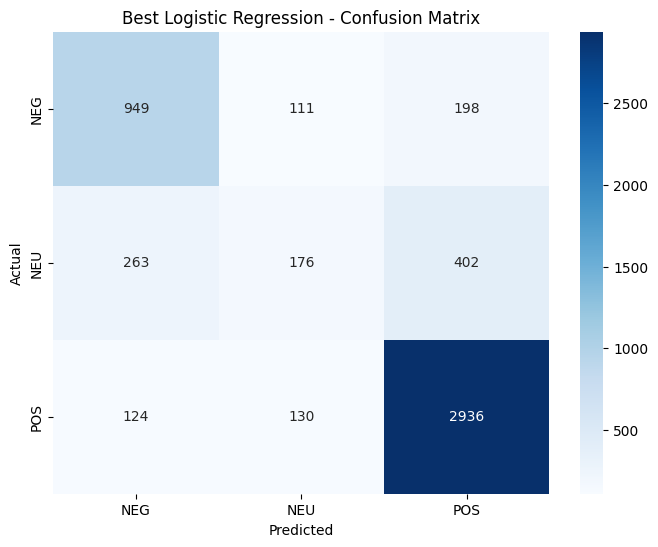


8. Prediction Analysis...
Correct predictions: 4061/5289 (0.7678)

Some incorrect predictions:
Text: hình ảnh và sản phẩm khác 1 trời 1 vực quả bóng rổ mà bé như quả trứng gà...
Actual: NEG, Predicted: POS

Text: sản phẩm chống tuột okay it mút ai ngực nhỏ mạc tạm dx...
Actual: POS, Predicted: NEU

Text: chất lượng sản phẩm tốt đóng gói sản phẩm chắc chắn đáng đồng tiền thời gian giao hàng nhanh...
Actual: NEU, Predicted: POS

Text: hàng chuẩn giá ổn...
Actual: NEU, Predicted: POS

Text: nhưng với giá chỉ 55k như vậy thì là khá tốt ạ mình áp thêm code giảm giá...
Actual: NEU, Predicted: POS

Text: chất lượng sản phẩm tốt nhưng góp ý cửa hàng nên dành thời gian check inb khách hơn mình nhắn không ...
Actual: NEU, Predicted: POS

Text: đóng gói sản phẩm rất đẹp và chắc chắn hàng không đẹp...
Actual: NEG, Predicted: POS

Text: đóng gói sản phẩm rất đẹp và chắc chắn tuy nhiên không có size để lựa chọn nó nhỏ và ngắn so với ngư...
Actual: POS, Predicted: NEU

Text: size không chuẩn...
Actu

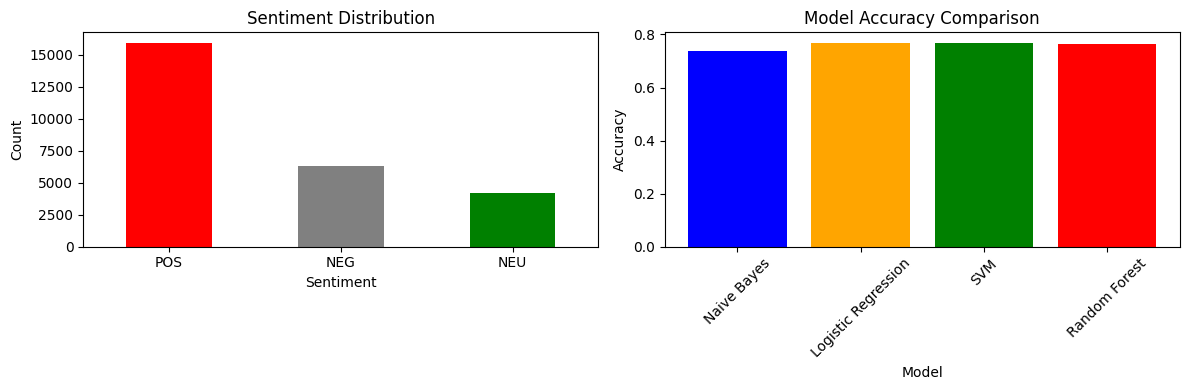

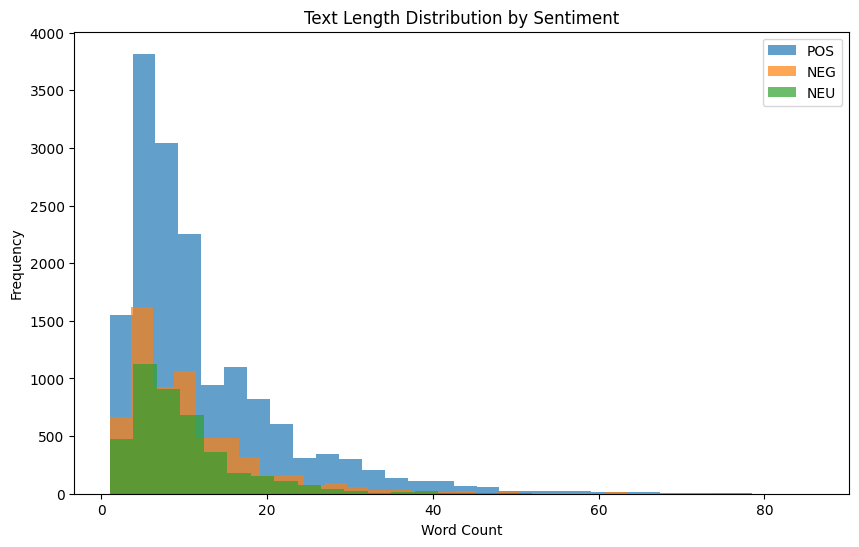

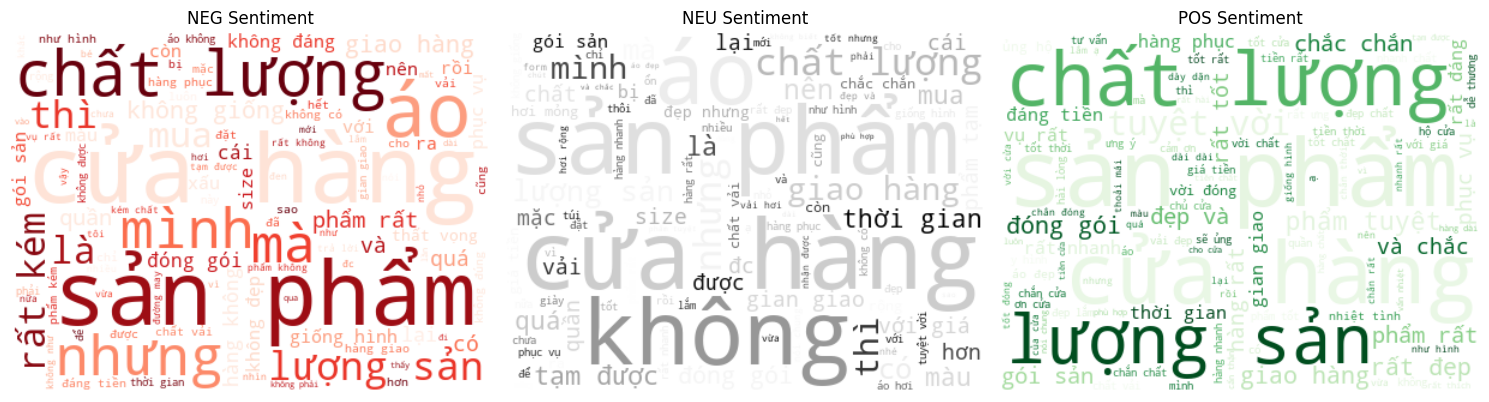


11. Saving Model...
Model saved to vietnamese_sentiment_model.pkl
Sentiment: Tích cực
Confidence: 0.9317


In [26]:
# 1. Load data
df = pd.read_csv('/Users/mement/Documents/Vietnamese Sentiment Analysis/data/data.csv')

# 2. Chạy pipeline hoàn chỉnh
analyzer, df_clean, results = main_pipeline(df)

# 3. Predict sentiment cho text mới
text = "Sản phẩm này rất tốt!"
result = analyzer.predict_sentiment(text)
print(f"Sentiment: {result['sentiment_vietnamese']}")
print(f"Confidence: {result['confidence']:.4f}")